# Model building

In [1]:
# Imports 

import requests
import zipfile
import os
import pandas as pd
import ftplib
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the merged and preprocessed data
data = pd.read_csv('data/preprocessed_data.csv')

In [3]:
data

,Unnamed: 0,EstimatedTime,LAT,LON,Heading,SOG_norm,COG_norm,GrossTonnage_norm,VHM0_norm,VMDR_norm,Temperature_norm,Salinity_norm
0,0,2020-01-01 00:00:00,36.80096,-75.22302,283.0,0.309783,0.185836,0.360360,0.216849,0.278556,0.375870,0.887591
1,1,2020-01-01 00:00:00,26.08420,-79.48273,187.0,0.331522,0.961661,0.515015,0.088924,0.052832,0.835220,0.982673
2,2,2020-01-01 00:00:00,29.34368,-94.74366,86.0,0.168478,0.709402,0.293093,0.018721,0.323412,0.490509,0.792078
3,3,2020-01-01 00:00:00,37.76973,-122.35415,326.0,0.190217,0.286447,0.293093,0.084243,0.745706,0.377345,0.641309
4,4,2020-01-01 00:00:00,26.89363,-79.20262,155.0,0.684783,0.878388,0.451652,0.092044,0.022122,0.808156,0.987242
...,...,...,...,...,...,...,...,...,...,...,...,...
566841,720152,2020-10-02 00:00:00,26.05327,-79.84955,5.0,0.684783,0.510379,0.371572,0.107644,0.056417,0.944354,0.973406
566842,720153,2020-10-02 00:00:00,28.44555,-95.59912,57.0,0.315217,0.636874,0.479279,0.037441,0.305431,0.861402,0.840567
566843,720154,2020-10-02 00:00:00,39.18945,-130.91286,280.0,0.695652,0.183639,0.706306,0.404056,0.767189,0.674095,0.874057
566844,720155,2020-10-02 00:00:00,17.18697,-67.33857,110.0,0.250000,0.768742,0.302703,0.371295,0.258602,0.934577,0.935218


## Simple model: linear regression

In [4]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [5]:
# target 
y = data.SOG_norm

# predictors
features = ['VHM0_norm','VMDR_norm','Temperature_norm','Salinity_norm'] 
X = data[features]

# split data to train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [6]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
# R2: 1 is perfect prediction
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Coefficients: 
 [0.14661334 0.04047778 0.13590311 0.08404383]
Mean squared error: 0.03
R^2: 0.04


## Intermediate model: Random forest

In [7]:
from joblib import dump, load
from pathlib import Path

my_file = Path("data/rf_model.joblib")
if my_file.is_file():
    forest_model = load('data/rf_model.joblib') 
else:
    forest_model = RandomForestRegressor(random_state=1)
    forest_model.fit(train_X, train_y)
    pred_y = forest_model.predict(val_X)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(val_y, pred_y))
    # R2: 1 is perfect prediction
    print('R^2: %.2f'
          % r2_score(val_y, pred_y))
    dump(forest_model, 'data/rf_model.joblib') 

#Add variable importance
feature_importance_values = forest_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

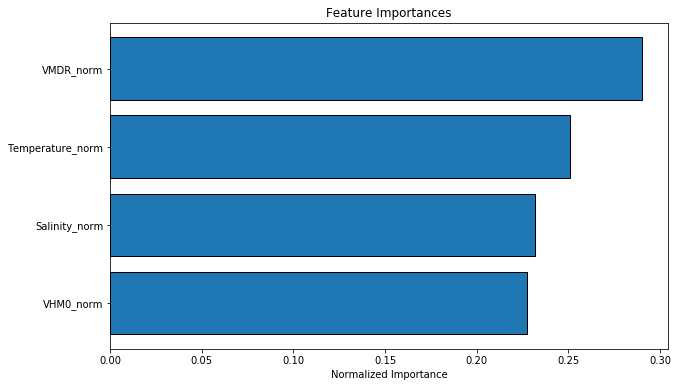

In [8]:
def plot_feature_importances(df):
    """Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called 'importance'
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Routing

In [9]:
# Join all wave products by using open_mfdataset, chunking data in response to memory issues
wav_all = xr.open_mfdataset('data/routing/mf*.nc')
wav_all

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 24)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2021-06-04
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_WW    (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VHM0_WW    (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_SW1   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM01_SW1  (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_SW2   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    ...         ...
    VTPK       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VSDX       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VSDY       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VPED       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM02      (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM01_WW   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                   CF-1.6
    time_coverage_start:           20210601-03:00:00
    time_coverage_end:             20210602-00:00:00
    date_created:                  20210602-06:32:00
    product_type:                  hindcast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    ...                            ...
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

In [10]:
phy_all = xr.open_mfdataset('data/routing/me*.nc')
phy_all

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 2041, longitude: 4320, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time       (time) datetime64[ns] 2021-06-01T12:00:00 ... 2021-06-03T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2021/06/06 19:06:21 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR PSY4V3R1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

### Area of interest

Calculate the optimal shipping route between Lisbon and Rio de Janeiro avoiding high waves.

Lisbon: 38.716666° N 9.1667° W

Rio de Janeiro: 22.908333° S 43.196389° W

In [11]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [12]:
# Set bounding box for the allowed routing corridor
bbox = ((-45, -25),(-10, 40))
# Select time
time_slice_wav = 3
time_slice_phy = 0

In [13]:
# Get indices of the bbox
lon_min = get_closest(wav_all.longitude.data, bbox[0][0])
lat_min = get_closest(wav_all.latitude.data, bbox[0][1])
lon_max = get_closest(wav_all.longitude.data, bbox[1][0])
lat_max = get_closest(wav_all.latitude.data, bbox[1][1])

## Define the weights

## Very simple solution: Calculate optimal route (minimum cost path) based on one variable _wave height_ for _one_ day

In [14]:
# Extract array from dataset to define the cost in the routing algorithm 
# Wave height
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

### Start and end point of the route

In [15]:
lat_Lis = 38.716666
lon_Lis = -9.1667
lat_Rio = -22.908333
lon_Rio = -43.196389

In [16]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [17]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

In [18]:
wh_costs = wave_height.data
wd_costs = wave_dir.data
temp_costs = temp.data
sal_costs = sal.data

# Set NaN values to large wh_costs as the algorithm cannot handle NaNs
wh_costs[np.isnan(wh_costs)] = 2 * np.nanmax(wh_costs) 
wd_costs[np.isnan(wd_costs)] = 2 * np.nanmax(wd_costs) 
temp_costs[np.isnan(temp_costs)] = 2 * np.nanmax(temp_costs) 
sal_costs[np.isnan(sal_costs)] = 2 * np.nanmax(sal_costs) 

In [19]:
# Standardization and normalization of weights
def stand_and_norm (x):
    # Standardization
    x_stand = (x - np.mean(x)) / np.std(x)
    # Normalization
    x_norm = (x_stand - np.min(x_stand)) / (np.max(x_stand) - np.min(x_stand))
    return x_norm

wh_costs = stand_and_norm(wh_costs)
wd_costs = stand_and_norm(wd_costs)
temp_costs = stand_and_norm(temp_costs)
sal_costs = stand_and_norm(sal_costs)

In [20]:
# Weight are taken from linear regression model
speed = 0.14661334*wh_costs + 0.04047778*wd_costs + 0.13590311*temp_costs + 0.08404383*sal_costs

# invert costs, because costs imitate speed 
inverted_speed = -1 * speed + np.abs(np.max(speed))
# assign non-water areas high values
inverted_speed[inverted_speed == 0] = 2*np.max(inverted_speed)

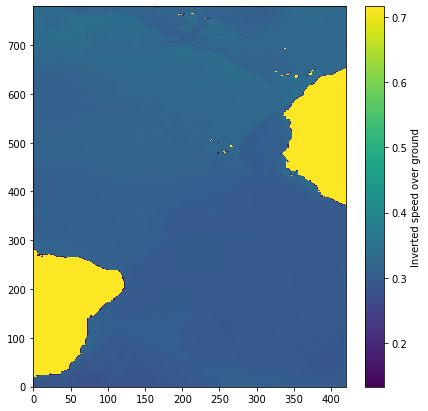

In [21]:
x = (temp_costs - np.mean(temp_costs)) / np.std(temp_costs)

# Plot modelled speed
plt.figure(figsize=(7,7))

# Costs
plt.imshow(inverted_speed, aspect='auto')#, vmin=np.min(wd_costs), vmax=np.max(wd_costs))
plt.gca().invert_yaxis()
plt.colorbar(label='Inverted speed over ground')
plt.show()

In [22]:
from skimage.graph import route_through_array

# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

wh_indices, weight = route_through_array(wh_costs, start, end, fully_connected=True, geometric=False)
wh_indices = np.stack(wh_indices, axis=-1)

wd_indices, weight = route_through_array(wd_costs, start, end, fully_connected=True, geometric=False)
wd_indices = np.stack(wd_indices, axis=-1)

temp_indices, weight = route_through_array(temp_costs, start, end, fully_connected=True, geometric=False)
temp_indices = np.stack(temp_indices, axis=-1)

sal_indices, weight = route_through_array(sal_costs, start, end, fully_connected=True, geometric=False)
sal_indices = np.stack(sal_indices, axis=-1)

merged_indices, weight = route_through_array(inverted_speed, start, end, fully_connected=True, geometric=True)
merged_indices = np.stack(merged_indices, axis=-1)

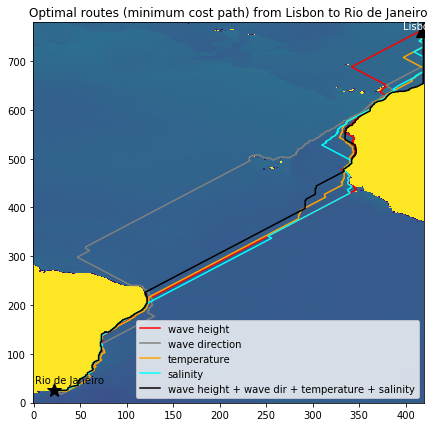

In [23]:
# Plot optimal route
plt.figure(figsize=(7,7))

# Costs
plt.imshow(inverted_speed, aspect='auto', vmin=np.min(inverted_speed), vmax=np.max(inverted_speed))

# Routes
plt.plot(wh_indices[1],wh_indices[0], 'red', label = "wave height")
plt.plot(wd_indices[1],wd_indices[0], 'grey', label = "wave direction")
plt.plot(temp_indices[1],temp_indices[0], 'orange', label = "temperature")
plt.plot(sal_indices[1],sal_indices[0], 'cyan', label = "salinity")
plt.plot(merged_indices[1],merged_indices[0], 'black', label = "wave height + wave dir + temperature + salinity")

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15)
plt.text(start_lon - 22, start_lat, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.text(end_lon - 20, end_lat + 15, "Rio de Janeiro")
plt.title("Optimal routes (minimum cost path) from Lisbon to Rio de Janeiro")
plt.legend(loc = "lower right")
plt.gca().invert_yaxis()

# TODO: Add reference route the ships usually take

## Advanced solution: Calculate optimal route (minimum cost path) based on *multiple* variables and *multiple* days

In [24]:
# Show times for WAV
time = phy_all.sel(time=~phy_all.get_index("time").duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_phy = str(time.values[step])
    rows.append([step, time_df_phy])

time_df_phy = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [25]:
# Show times for PHY
time = wav_all.sel(time=~wav_all.get_index("time").duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_wav = str(time.values[step])
    rows.append([step, time_df_wav])

time_df_wav = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [26]:
# Get the times that exist in both datasets (12:00:00 for the three days)
common_time = np.intersect1d(time_df_wav['Time'], time_df_phy['Time'])

# Create arrays with the corresponding steps
# For waves forecast, this is: [3, 11, 19, 27]
# For physics forecast, this is: [0, 1, 2, 3]
time_wav = []
time_phy = []

for t in range(common_time.size):
    time_wav.append(int(time_df_wav['Step'].loc[time_df_wav['Time'] == common_time[t]]))
    time_phy.append(int(time_df_phy['Step'].loc[time_df_phy['Time'] == common_time[t]]))

# Create time slices (start, end, step)
step_wav = time_wav[1] - time_wav[0]
time_slice_wav = slice(min(time_wav), max(time_wav) + 1, step_wav)
step_phy = time_phy[1] - time_phy[0]
time_slice_phy = slice(min(time_phy), max(time_phy) + 1, step_phy)

In [27]:
# Create multidimensional data (including time)
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

In [28]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [29]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

In [30]:
# Calculate multidimensional costs
wh_costs = wave_height
wh_costs = wh_costs.fillna(2 * np.nanmax(wh_costs))

wd_costs = wave_dir
wd_costs = wd_costs.fillna(2 * np.nanmax(wd_costs))

temp_costs = temp
temp_costs = temp_costs.fillna(2 * np.nanmax(temp_costs))
temp_costs = temp_costs.reindex(latitude = wh_costs.latitude, method='nearest', tolerance=123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance=123)

sal_costs = sal
sal_costs = sal_costs.fillna(2 * np.nanmax(sal_costs))
sal_costs = sal_costs.reindex(latitude = wh_costs.latitude, method='nearest', tolerance=123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance=123)

costs = 0.14661334 * wh_costs + 0.04047778 * wd_costs + 0.13590311 * temp_costs + 0.08404383 * sal_costs
costs

<xarray.DataArray (time: 3, latitude: 780, longitude: 420)>
dask.array<add, shape=(3, 780, 420), dtype=float32, chunksize=(1, 780, 420), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -45.0 -44.92 -44.83 ... -10.25 -10.17 -10.08
  * latitude   (latitude) float64 -25.0 -24.92 -24.83 ... 39.75 39.83 39.92
  * time       (time) datetime64[ns] 2021-06-01T12:00:00 ... 2021-06-03T12:00:00
    depth      float32 0.494

In [31]:
# Get data for specific timestep
costs_one_time = costs.sel(time = '2021-06-01T12:00:00')
costs_one_time

<xarray.DataArray (latitude: 780, longitude: 420)>
dask.array<getitem, shape=(780, 420), dtype=float32, chunksize=(780, 420), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -45.0 -44.92 -44.83 ... -10.25 -10.17 -10.08
  * latitude   (latitude) float64 -25.0 -24.92 -24.83 ... 39.75 39.83 39.92
    time       datetime64[ns] 2021-06-01T12:00:00
    depth      float32 0.494

In [32]:
# Sum costs for all timesteps
costs_all_times = costs.sum(dim = 'time')

In [33]:
# Calculate optimal route based on the minimum cost path
merged_indices_all_times, weight = route_through_array(costs_all_times, start, end, fully_connected=True, geometric=False)
merged_indices_all_times = np.stack(merged_indices_all_times, axis=-1)

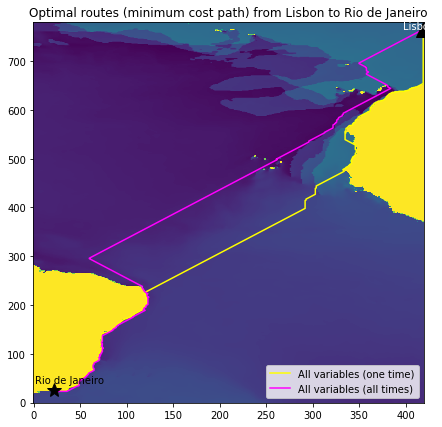

In [34]:
# Plot optimal route
plt.figure(figsize=(7,7))

# Costs
plt.imshow(costs_all_times, aspect='auto', vmin=np.min(costs_all_times.values), vmax=np.max(costs_all_times.values))

# Routes
plt.plot(merged_indices[1], merged_indices[0], 'yellow', label = "All variables (one time)")
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'magenta', label = "All variables (all times)")

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15)
plt.text(start_lon - 22, start_lat, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon - 20, end_lat + 15, "Rio de Janeiro")
plt.title("Optimal routes (minimum cost path) from Lisbon to Rio de Janeiro")
plt.legend(loc = "lower right")
plt.gca().invert_yaxis()

References:
* https://levelup.gitconnected.com/dijkstras-shortest-path-algorithm-in-a-grid-eb505eb3a290
* https://gist.github.com/mdsrosa/c71339cb23b